
# CNN Cancer Detector
<img src="Melanoma.jpg" alt="Melanoma" width="500"/>

In [1]:
#import necessary libraries
from torch import nn

#import imgaug as ia
#import imgaug.augmenters as iaa
from torchvision import datasets
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torch import optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [2]:
#preprocess images

train_transform = transforms.Compose([transforms.RandomResizedCrop(299),
                                       transforms.RandomOrder([transforms.RandomChoice([transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(15)]),]),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
#make test transformer with no augmentation  
test_transform = transforms.Compose([transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])                                        

#make train,valid and test loaders
train_data = datasets.ImageFolder(root = 'train',transform = train_transform)
train_loader = DataLoader(train_data,shuffle = True,batch_size = 16,num_workers = 0)
valid_data =  datasets.ImageFolder(root = 'valid',transform = test_transform)
valid_loader = DataLoader(valid_data,shuffle = True,batch_size = 16,num_workers = 0)
test_data = datasets.ImageFolder(root = 'test',transform = test_transform)
test_loader = DataLoader(test_data,shuffle = True,batch_size = 16,num_workers = 0)

train_iter = iter(train_loader)
data,label = train_iter.next()
data = data.numpy()
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
loaders['test'] = test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

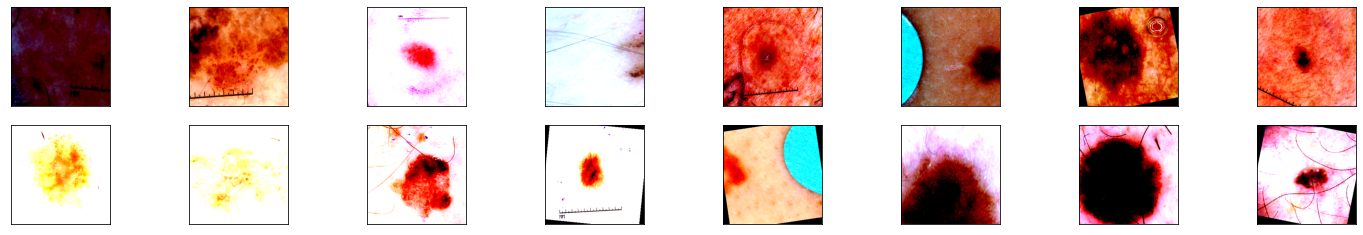

In [3]:
#visualize augmented training data
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
fig = plt.figure(figsize=(25, 4))
# display 32 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
  

In [4]:
#load efficientnet model from 
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\seand/.cache\torch\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:10<00:00, 1.98MB/s]
Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_

In [5]:

#alter last layer to fit 3 classes.
model._dropout = nn.Sequential(nn.Dropout(p=0.5))
model._fc = nn.Sequential(nn.Linear(1280,3))


In [6]:
#set up crtierion and optimizer
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [7]:
# the following import is required for training to be robust to truncated images
#Modified training loop courtesy of Udacity.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path,early_stop_round):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    early_stopping =0 
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                loss = criterion(output,target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            early_stopping=0
            print('SAVING MODEL')
        else:
            #if early we dont get a best score in 10
            early_stopping += 1
            if early_stopping >= early_stop_round:
                return model
    return model
            
    # return trained model




# train and load the model that got the best validation accuracy
model = train(100,loaders,model,optimizer,criterion,True,'torch_updated_trained_model.pt',6)
model.load_state_dict(torch.load('torch_updated_trained_model.pt'))

Epoch: 1 	Training Loss: 0.748387 	Validation Loss: 1.452522
SAVING MODEL
Epoch: 2 	Training Loss: 0.653715 	Validation Loss: 1.325474
SAVING MODEL
Epoch: 3 	Training Loss: 0.647144 	Validation Loss: 1.226386
SAVING MODEL
Epoch: 4 	Training Loss: 0.596893 	Validation Loss: 0.513393
SAVING MODEL
Epoch: 5 	Training Loss: 0.607324 	Validation Loss: 1.088313
Epoch: 6 	Training Loss: 0.578847 	Validation Loss: 0.766335
Epoch: 7 	Training Loss: 0.566285 	Validation Loss: 0.691798
Epoch: 8 	Training Loss: 0.520433 	Validation Loss: 0.825885
Epoch: 9 	Training Loss: 0.549017 	Validation Loss: 0.666196
Epoch: 10 	Training Loss: 0.516377 	Validation Loss: 0.565221


<All keys matched successfully>

In [8]:
def test(loaders, model, criterion, use_cuda):
#Modified testing loop courtesy of Udacity.
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        with torch.no_grad():
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model, criterion, True)

Test Loss: 0.576523


Test Accuracy: 76% (456/600)
